# QVM ENGINE V3J TEARSHEET DEMONSTRATION - MOVING AVERAGE POSITION SIZING

This notebook demonstrates the QVM (Quality, Value, Momentum) factor investing strategy with comprehensive performance analysis and visualization.

**Key Changes:** 
- Moving average-based position sizing: 50% allocation when index below 60-day MA
- Fixed portfolio size: exactly 20 stocks per rebalancing date
- Uses fixed factor weights: Quality 33%, Value 33%, Momentum 34%
- Dynamic allocation: 100% when above MA, 50% when below MA

# IMPORTS AND SETUP

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [23]:
import sys
sys.path.append('/home/raymond/Documents/Projects/factor-investing-public')
from production.database.connection import DatabaseManager

# MOVING AVERAGE STRATEGY - DYNAMIC POSITION SIZING

In [24]:
class MovingAverageStrategy:
    """
    QVM strategy with moving average-based position sizing.
    """
    def __init__(self, ma_period: int = 60, below_ma_allocation: float = 0.5):
        self.ma_period = ma_period
        self.below_ma_allocation = below_ma_allocation
        self.above_ma_allocation = 1.0
        
        print(f"✅ MovingAverageStrategy initialized:")
        print(f"   - Moving Average Period: {self.ma_period} days")
        print(f"   - Above MA Allocation: {self.above_ma_allocation:.0%}")
        print(f"   - Below MA Allocation: {self.below_ma_allocation:.0%}")
        print(f"   - Factor Weights: Quality 33.33%, Value 33.33%, Momentum 33.34%")
    
    def calculate_moving_average(self, benchmark_data: pd.DataFrame) -> pd.DataFrame:
        """Calculate moving average for the benchmark."""
        benchmark_data = benchmark_data.sort_values('date').copy()
        benchmark_data['ma_60'] = benchmark_data['close_price'].rolling(self.ma_period).mean()
        benchmark_data['above_ma'] = benchmark_data['close_price'] > benchmark_data['ma_60']
        return benchmark_data
    
    def get_allocation(self, benchmark_data: pd.DataFrame, date) -> float:
        """Get target allocation based on moving average position."""
        # Find the benchmark data for this date
        date_data = benchmark_data[benchmark_data['date'] == date]
        
        if not date_data.empty:
            above_ma = date_data['above_ma'].iloc[0]
            return self.above_ma_allocation if above_ma else self.below_ma_allocation
        else:
            # If no data found, use the most recent available data
            available_data = benchmark_data[benchmark_data['date'] <= date]
            if not available_data.empty:
                latest_data = available_data.iloc[-1]
                above_ma = latest_data['above_ma']
                return self.above_ma_allocation if above_ma else self.below_ma_allocation
            else:
                # Default to full allocation if no data available
                return self.above_ma_allocation

# CONFIGURATION

In [25]:
CONFIG = {
    'strategy_name': 'QVM_Engine_v3j_Moving_Avg_Demo',
    'universe': {
        'lookback_days': 252,
        'top_n_stocks': 20,
        'target_portfolio_size': 20,
        'adtv_threshold_bn': 10,  # 10 billion VND ADTV
    },
    'backtest_start_date': '2016-01-01',
    'backtest_end_date': '2025-12-31',
    'rebalance_frequency': 'M',  # Monthly
    'transaction_cost_bps': 10,  # 10 basis points
    'initial_capital': 10_000_000_000,  # 10 billion VND
    'moving_average': {
        'period': 60,         # 60-day moving average
        'below_ma_allocation': 0.5,  # 50% allocation when below MA
        'above_ma_allocation': 1.0   # 100% allocation when above MA
    },
    'factor_weights': {
        'quality': 0.3333,    # 33.33% Quality
        'value': 0.3333,      # 33.33% Value  
        'momentum': 0.3334,   # 33.34% Momentum
    }
}

# DATABASE CONNECTION

In [26]:
# Initialize database connection
db_manager = DatabaseManager()
engine = db_manager.get_engine()
print("✅ Database connected")

2025-08-08 01:17:38,312 - production.database.connection - INFO - Database configuration loaded from /home/raymond/Documents/Projects/factor-investing-public/config/database.yml
2025-08-08 01:17:38,313 - production.database.connection - INFO - DatabaseManager initialized for environment: production
2025-08-08 01:17:38,313 - production.database.connection - INFO - All database connections closed
2025-08-08 01:17:38,318 - production.database.connection - INFO - SQLAlchemy engine created successfully


✅ Database connected


# LOAD HOLDINGS DATA

In [27]:
# Load holdings data from pre-generated file
holdings_file = Path("docs/18b_complete_holdings.csv")
if holdings_file.exists():
    holdings_df = pd.read_csv(holdings_file)
    holdings_df['date'] = pd.to_datetime(holdings_df['date']).dt.date
    print(f"✅ Loaded holdings: {len(holdings_df)} records")
else:
    print("❌ Holdings file not found, using database query...")
    query = """
    SELECT date, ticker, Quality_Composite as quality_score, Value_Composite as value_score, 
           Momentum_Composite as momentum_score, QVM_Composite as composite_score
    FROM factor_scores_qvm 
    WHERE date BETWEEN %s AND %s
    ORDER BY date, QVM_Composite DESC
    """
    holdings_df = pd.read_sql(query, engine, params=(CONFIG['backtest_start_date'], CONFIG['backtest_end_date']))
    holdings_df['date'] = pd.to_datetime(holdings_df['date']).dt.date
    print(f"✅ Loaded holdings: {len(holdings_df)} records")

✅ Loaded holdings: 75539 records


# LOAD PRICE DATA

In [28]:
print("📊 Loading price data...")
unique_tickers = holdings_df['ticker'].unique()
ticker_list = "', '".join(unique_tickers)

price_query = f"""
SELECT 
    trading_date as date,
    ticker,
    close_price
FROM vcsc_daily_data_complete
WHERE ticker IN ('{ticker_list}')
AND trading_date >= '{holdings_df['date'].min()}'
AND trading_date <= '{holdings_df['date'].max()}'
ORDER BY trading_date, ticker
"""

price_data = pd.read_sql(price_query, engine)
price_data['date'] = pd.to_datetime(price_data['date']).dt.date
print(f"✅ Price data: {len(price_data)} records")

📊 Loading price data...
✅ Price data: 1581176 records


# LOAD BENCHMARK DATA

In [29]:
print("📊 Loading benchmark data...")
benchmark_query = f"""
SELECT 
    date,
    close as close_price
FROM etf_history
WHERE ticker = 'VNINDEX'
AND date >= '{holdings_df['date'].min()}'
AND date <= '{holdings_df['date'].max()}'
ORDER BY date
"""

benchmark_data = pd.read_sql(benchmark_query, engine)
benchmark_data['date'] = pd.to_datetime(benchmark_data['date']).dt.date
benchmark_data['return'] = benchmark_data['close_price'].pct_change()
print(f"✅ Benchmark data: {len(benchmark_data)} records")

📊 Loading benchmark data...
✅ Benchmark data: 2369 records


# INITIALIZE MOVING AVERAGE STRATEGY

In [30]:
# Initialize moving average strategy
strategy = MovingAverageStrategy(
    ma_period=CONFIG['moving_average']['period'],
    below_ma_allocation=CONFIG['moving_average']['below_ma_allocation']
)
print(f"✅ Moving average strategy initialized")

# Calculate moving average for benchmark
benchmark_data = strategy.calculate_moving_average(benchmark_data)
print(f"✅ Moving average calculated for benchmark")

# Debug: Show some sample moving average data
print(f"🔍 Sample Moving Average Data:")
sample_ma_data = benchmark_data[['date', 'close_price', 'ma_60', 'above_ma']].dropna().head(10)
for _, row in sample_ma_data.iterrows():
    print(f"   {row['date']}: Price={row['close_price']:.0f}, MA={row['ma_60']:.0f}, Above_MA={row['above_ma']}")

✅ MovingAverageStrategy initialized:
   - Moving Average Period: 60 days
   - Above MA Allocation: 100%
   - Below MA Allocation: 50%
   - Factor Weights: Quality 33.33%, Value 33.33%, Momentum 33.34%
✅ Moving average strategy initialized
✅ Moving average calculated for benchmark
🔍 Sample Moving Average Data:
   2016-04-01: Price=558, MA=559, Above_MA=False
   2016-04-04: Price=556, MA=558, Above_MA=False
   2016-04-05: Price=560, MA=558, Above_MA=True
   2016-04-06: Price=568, MA=558, Above_MA=True
   2016-04-07: Price=572, MA=558, Above_MA=True
   2016-04-08: Price=572, MA=558, Above_MA=True
   2016-04-11: Price=579, MA=559, Above_MA=True
   2016-04-12: Price=580, MA=559, Above_MA=True
   2016-04-13: Price=578, MA=559, Above_MA=True
   2016-04-14: Price=579, MA=560, Above_MA=True


# CALCULATE PORTFOLIO RETURNS

In [31]:
def calculate_corrected_returns(holdings_df, price_data, benchmark_data, config, strategy):
    """Calculate corrected portfolio returns with moving average-based allocation."""
    print("📈 Calculating corrected portfolio returns with moving average-based allocation...")
    
    # Convert dates to datetime
    holdings_df['date'] = pd.to_datetime(holdings_df['date'])
    price_data['date'] = pd.to_datetime(price_data['date'])
    benchmark_data['date'] = pd.to_datetime(benchmark_data['date'])
    
    # Create price matrix with forward filling
    print("   📊 Creating price matrix with forward filling...")
    price_matrix = price_data.pivot(index='date', columns='ticker', values='close_price')
    
    # Forward fill prices (carry last known price forward)
    price_matrix = price_matrix.fillna(method='ffill')
    
    # Backward fill any remaining NaN values at the beginning
    price_matrix = price_matrix.fillna(method='bfill')
    
    print(f"   ✅ Price matrix created: {price_matrix.shape}")
    
    # Get unique rebalancing dates
    unique_dates = sorted(holdings_df['date'].unique())
    
    portfolio_values = []
    daily_returns = []
    current_capital = config['initial_capital']
    
    for i, date in enumerate(unique_dates):
        # Get holdings for this date
        date_holdings = holdings_df[holdings_df['date'] == date]
        
        if date_holdings.empty:
            continue
        
        # Get dynamic allocation based on moving average
        allocation = strategy.get_allocation(benchmark_data, date)
        
        # Get prices for this date from the forward-filled matrix
        if date in price_matrix.index:
            date_prices = price_matrix.loc[date]
        else:
            # Find the closest available date
            available_dates = price_matrix.index[price_matrix.index <= date]
            if not available_dates.empty:
                closest_date = available_dates[-1]
                date_prices = price_matrix.loc[closest_date]
            else:
                continue
        
        # Calculate portfolio value with regime-based allocation
        portfolio_value = 0
        valid_holdings = 0
        
        for _, holding in date_holdings.iterrows():
            ticker = holding['ticker']
            if ticker in date_prices.index:
                price = date_prices[ticker]
                if pd.notna(price) and price > 0:
                    # Apply fixed allocation
                    position_size = (current_capital * allocation) / len(date_holdings)
                    shares = position_size / price
                    portfolio_value += shares * price
                    valid_holdings += 1
        
        if portfolio_value > 0 and valid_holdings > 0:
            # Get MA status for this date
            ma_status = "Above MA" if allocation == 1.0 else "Below MA"
            
            portfolio_values.append({
                'date': date,
                'portfolio_value': portfolio_value,
                'capital': current_capital,
                'valid_holdings': valid_holdings,
                'total_holdings': len(date_holdings),
                'allocation': allocation,
                'ma_status': ma_status
            })
            
            # Calculate daily returns for the period until next rebalancing
            if i < len(unique_dates) - 1:
                next_date = unique_dates[i + 1]
                
                # Get price data for the period (only trading days)
                period_dates = price_matrix.index[
                    (price_matrix.index >= date) & 
                    (price_matrix.index <= next_date)
                ]
                
                if len(period_dates) > 1:
                    # Calculate daily returns for each stock
                    period_prices = price_matrix.loc[period_dates]
                    
                    # Calculate daily returns (pct_change)
                    period_returns = period_prices.pct_change()
                    
                    # Calculate portfolio daily returns
                    for daily_date in period_returns.index[1:]:  # Skip first date (no return)
                        daily_returns_data = period_returns.loc[daily_date]
                        
                        # Get only the stocks in our portfolio
                        portfolio_tickers = date_holdings['ticker'].unique()
                        portfolio_daily_returns = daily_returns_data[daily_returns_data.index.isin(portfolio_tickers)]
                        
                        if not portfolio_daily_returns.empty:
                            # Filter out extreme returns (likely data errors)
                            portfolio_daily_returns = portfolio_daily_returns[
                                (portfolio_daily_returns >= -0.5) & (portfolio_daily_returns <= 0.5)
                            ]
                            
                            if len(portfolio_daily_returns) > 0:
                                # Equal weight portfolio return
                                portfolio_return = portfolio_daily_returns.mean()
                                
                                # Apply allocation factor to daily returns
                                portfolio_return = portfolio_return * allocation
                                
                                # Apply transaction costs on rebalancing day
                                if daily_date == date:
                                    transaction_cost = config['transaction_cost_bps'] / 10000
                                    portfolio_return -= transaction_cost
                                
                                # Only include valid returns (not NaN or extreme)
                                if pd.notna(portfolio_return) and abs(portfolio_return) < 0.5:
                                    daily_returns.append({
                                        'date': daily_date,
                                        'portfolio_return': portfolio_return,
                                        'rebalance_date': date,
                                        'allocation': allocation,
                                        'ma_status': ma_status
                                    })
            
            # Update capital for next period
            current_capital = portfolio_value
    
    portfolio_df = pd.DataFrame(portfolio_values)
    daily_returns_df = pd.DataFrame(daily_returns)
    
    print(f"   ✅ Portfolio values: {len(portfolio_df)} records")
    print(f"   ✅ Daily returns: {len(daily_returns_df)} records")
    print(f"   📊 Moving average-based allocation applied")
    
    return portfolio_df, daily_returns_df

In [32]:
def apply_fixed_factor_weights(holdings_df, config):
    """Apply fixed factor weights to holdings data."""
    print("📊 Applying fixed factor weights...")
    
    # Apply fixed factor weights
    holdings_df['composite_score_adjusted'] = (
        holdings_df['quality_score'] * config['factor_weights']['quality'] +
        holdings_df['value_score'] * config['factor_weights']['value'] +
        holdings_df['momentum_score'] * config['factor_weights']['momentum']
    )
    
    # Sort by adjusted composite score within each date
    holdings_df = holdings_df.sort_values(['date', 'composite_score_adjusted'], ascending=[True, False])
    
    # Select top N stocks based on adjusted composite score to fix portfolio size
    print(f"   📊 Selecting top {config['universe']['target_portfolio_size']} stocks per date...")
    holdings_df = holdings_df.groupby('date').head(config['universe']['target_portfolio_size']).reset_index(drop=True)
    
    print(f"   ✅ Fixed factor weights applied")
    print(f"   📊 Factor weights:")
    print(f"      Quality: {config['factor_weights']['quality']:.1%}")
    print(f"      Value: {config['factor_weights']['value']:.1%}")
    print(f"      Momentum: {config['factor_weights']['momentum']:.1%}")
    
    # Verify portfolio size is fixed
    portfolio_sizes = holdings_df.groupby('date').size()
    print(f"   📊 Portfolio size verification:")
    print(f"      Min portfolio size: {portfolio_sizes.min()}")
    print(f"      Max portfolio size: {portfolio_sizes.max()}")
    print(f"      Target portfolio size: {config['universe']['target_portfolio_size']}")
    
    return holdings_df

In [33]:
# Apply fixed factor weights
holdings_df_adjusted = apply_fixed_factor_weights(holdings_df, CONFIG)

📊 Applying fixed factor weights...
   📊 Selecting top 20 stocks per date...
   ✅ Fixed factor weights applied
   📊 Factor weights:
      Quality: 33.3%
      Value: 33.3%
      Momentum: 33.3%
   📊 Portfolio size verification:
      Min portfolio size: 20
      Max portfolio size: 20
      Target portfolio size: 20


In [34]:
# Calculate returns with moving average-based allocation
portfolio_values, daily_returns = calculate_corrected_returns(holdings_df_adjusted, price_data, benchmark_data, CONFIG, strategy)

# Analyze moving average strategy performance
print("\n" + "="*80)
print("📊 MOVING AVERAGE STRATEGY ANALYSIS")
print("="*80)

# Count MA status distribution
ma_counts = portfolio_values['ma_status'].value_counts()
print(f"📈 Moving Average Status Distribution:")
for status, count in ma_counts.items():
    percentage = count / len(portfolio_values) * 100
    print(f"   {status}: {count} rebalances ({percentage:.1f}%)")

# Calculate average allocation
avg_allocation = portfolio_values['allocation'].mean()
print(f"📊 Average Allocation: {avg_allocation:.1%}")

# Show some sample periods
print(f"📅 Sample Moving Average Periods:")
sample_periods = portfolio_values[['date', 'ma_status', 'allocation']].head(10)
for _, row in sample_periods.iterrows():
    print(f"   {row['date']}: {row['ma_status']} (Allocation: {row['allocation']:.0%})")

# Debug: Check if allocations are actually different
unique_allocations = portfolio_values['allocation'].unique()
print(f"🔍 Unique allocations found: {unique_allocations}")
if len(unique_allocations) == 1:
    print("⚠️ WARNING: Only one allocation value found! Moving average strategy may not be working.")
else:
    print(f"✅ Moving average strategy is working - multiple allocation values detected")

# Debug: Check benchmark data for moving average
print(f"🔍 Benchmark data columns: {benchmark_data.columns.tolist()}")
if 'ma_60' in benchmark_data.columns:
    print(f"✅ Moving average calculated successfully")
    print(f"   Sample MA values: {benchmark_data['ma_60'].dropna().head().tolist()}")
else:
    print("⚠️ WARNING: Moving average not found in benchmark data!")

📈 Calculating corrected portfolio returns with moving average-based allocation...
   📊 Creating price matrix with forward filling...
   ✅ Price matrix created: (2371, 714)
   ✅ Portfolio values: 115 records
   ✅ Daily returns: 2370 records
   📊 Moving average-based allocation applied

📊 MOVING AVERAGE STRATEGY ANALYSIS
📈 Moving Average Status Distribution:
   Above MA: 73 rebalances (63.5%)
   Below MA: 42 rebalances (36.5%)
📊 Average Allocation: 81.7%
📅 Sample Moving Average Periods:
   2016-01-04 00:00:00: Below MA (Allocation: 50%)
   2016-02-01 00:00:00: Below MA (Allocation: 50%)
   2016-03-01 00:00:00: Below MA (Allocation: 50%)
   2016-04-01 00:00:00: Below MA (Allocation: 50%)
   2016-05-04 00:00:00: Above MA (Allocation: 100%)
   2016-06-01 00:00:00: Above MA (Allocation: 100%)
   2016-07-01 00:00:00: Above MA (Allocation: 100%)
   2016-08-01 00:00:00: Above MA (Allocation: 100%)
   2016-09-01 00:00:00: Above MA (Allocation: 100%)
   2016-10-03 00:00:00: Above MA (Allocation: 

# CALCULATE PERFORMANCE METRICS

In [35]:
def calculate_performance_metrics(portfolio_values, daily_returns, benchmark_data, config):
    """Calculate performance metrics with proper data handling."""
    print("📊 Calculating performance metrics...")
    
    if portfolio_values.empty or daily_returns.empty:
        print("   ⚠️ No data available for performance calculation")
        return {}
    
    # Process daily returns
    daily_returns = daily_returns.sort_values('date')
    daily_returns = daily_returns.dropna(subset=['portfolio_return'])
    
    # Filter out extreme returns
    daily_returns = daily_returns[
        (daily_returns['portfolio_return'] >= -0.5) & 
        (daily_returns['portfolio_return'] <= 0.5)
    ]
    
    if daily_returns.empty:
        print("   ⚠️ No valid daily returns")
        return {}
    
    # Merge with benchmark data
    daily_returns = daily_returns.merge(benchmark_data, on='date', how='left')
    daily_returns['benchmark_return'] = daily_returns['close_price'].pct_change()
    daily_returns = daily_returns.dropna(subset=['portfolio_return', 'benchmark_return'])
    
    if daily_returns.empty:
        print("   ⚠️ No valid data after benchmark merge")
        return {}
    
    print(f"   📊 Valid daily returns: {len(daily_returns)} records")
    
    # Calculate metrics with proper validation
    total_return = (1 + daily_returns['portfolio_return']).prod() - 1
    benchmark_total_return = (1 + daily_returns['benchmark_return']).prod() - 1
    
    # Annualized return
    days = (pd.to_datetime(daily_returns['date'].iloc[-1]) - pd.to_datetime(daily_returns['date'].iloc[0])).days
    if days > 0:
        annualized_return = (1 + total_return) ** (365.25 / days) - 1
        benchmark_annualized_return = (1 + benchmark_total_return) ** (365.25 / days) - 1
    else:
        annualized_return = 0
        benchmark_annualized_return = 0
    
    # Volatility
    volatility = daily_returns['portfolio_return'].std() * np.sqrt(252)
    benchmark_volatility = daily_returns['benchmark_return'].std() * np.sqrt(252)
    
    # Sharpe ratio
    risk_free_rate = 0.00  # 0% risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility > 0 else 0
    benchmark_sharpe_ratio = (benchmark_annualized_return - risk_free_rate) / benchmark_volatility if benchmark_volatility > 0 else 0
    
    # Maximum drawdown
    cumulative_returns = (1 + daily_returns['portfolio_return']).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Win rate
    win_rate = (daily_returns['portfolio_return'] > 0).mean()
    
    # Information ratio
    excess_returns = daily_returns['portfolio_return'] - daily_returns['benchmark_return']
    information_ratio = excess_returns.mean() / excess_returns.std() if excess_returns.std() > 0 else 0
    
    # Beta and Alpha
    covariance = np.cov(daily_returns['portfolio_return'], daily_returns['benchmark_return'])[0, 1]
    benchmark_variance = daily_returns['benchmark_return'].var()
    beta = covariance / benchmark_variance if benchmark_variance > 0 else 1.0
    alpha = annualized_return - (risk_free_rate + beta * (benchmark_annualized_return - risk_free_rate))
    
    # Calmar ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'information_ratio': information_ratio,
        'beta': beta,
        'alpha': alpha,
        'calmar_ratio': calmar_ratio,
        'days': len(daily_returns),
        'benchmark_total_return': benchmark_total_return,
        'benchmark_annualized_return': benchmark_annualized_return,
        'benchmark_volatility': benchmark_volatility,
        'benchmark_sharpe_ratio': benchmark_sharpe_ratio
    }
    
    print("   ✅ Performance metrics calculated successfully")
    return metrics

In [36]:
# Calculate performance metrics
performance_metrics = calculate_performance_metrics(portfolio_values, daily_returns, benchmark_data, CONFIG)

📊 Calculating performance metrics...
   📊 Valid daily returns: 2369 records
   ✅ Performance metrics calculated successfully


# GENERATE COMPREHENSIVE TEARSHEET

In [37]:
def generate_comprehensive_tearsheet(strategy_returns: pd.Series, benchmark_returns: pd.Series, diagnostics: pd.DataFrame, title: str):
    """Generates comprehensive institutional tearsheet with equity curve and analysis."""
    
    # Align benchmark for plotting & metrics
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    aligned_strategy_returns = strategy_returns.loc[first_trade_date:]
    aligned_benchmark_returns = benchmark_returns.loc[first_trade_date:]

    strategy_metrics = calculate_performance_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = calculate_performance_metrics(benchmark_returns, benchmark_returns)
    
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2)
    fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')

    # 1. Cumulative Performance (Equity Curve) with Regime Shading
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot the main equity curves
    (1 + aligned_strategy_returns).cumprod().plot(ax=ax1, label='QVM Engine v3j', color='#16A085', lw=2.5)
    (1 + aligned_benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index (Aligned)', color='#34495E', linestyle='--', lw=2)
    
    # Add moving average shading
    if not diagnostics.empty and 'ma_status' in diagnostics.columns:
        # Get MA status data aligned with the returns
        ma_data = diagnostics.reindex(aligned_strategy_returns.index, method='ffill')
        
        # Shade below MA periods (red with low alpha)
        below_ma_periods = ma_data[ma_data['ma_status'] == 'Below MA']
        if not below_ma_periods.empty:
            for i, date in enumerate(below_ma_periods.index):
                if i == 0 or (date - below_ma_periods.index[i-1]).days > 1:
                    # Start of a new below MA period
                    start_date = date
                    # Find the end of this below MA period
                    end_date = date
                    for j in range(i+1, len(below_ma_periods.index)):
                        if (below_ma_periods.index[j] - below_ma_periods.index[j-1]).days == 1:
                            end_date = below_ma_periods.index[j]
                        else:
                            break
                    ax1.axvspan(start_date, end_date, alpha=0.1, color='red', label='Below MA (50% Allocation)' if i == 0 else "")
        
        print(f"   📊 Moving average shading applied")
    else:
        print("   📊 No moving average data available for shading")
    
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
    ax1.set_ylabel('Growth of 1 VND')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)

    # 2. Drawdown Analysis
    ax2 = fig.add_subplot(gs[1, :])
    drawdown = ((1 + aligned_strategy_returns).cumprod() / (1 + aligned_strategy_returns).cumprod().cummax() - 1) * 100
    drawdown.plot(ax=ax2, color='#C0392B')
    ax2.fill_between(drawdown.index, drawdown, 0, color='#C0392B', alpha=0.1)
    ax2.set_title('Drawdown Analysis', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True, linestyle='--', alpha=0.5)

    # 3. Annual Returns
    ax3 = fig.add_subplot(gs[2, 0])
    strat_annual = aligned_strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    bench_annual = aligned_benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E'])
    ax3.set_xticks(range(len(strat_annual)))
    ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right')
    ax3.set_title('Annual Returns', fontweight='bold')
    ax3.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 4. Rolling Sharpe Ratio
    ax4 = fig.add_subplot(gs[2, 1])
    rolling_sharpe = (aligned_strategy_returns.rolling(252).mean() * 252) / (aligned_strategy_returns.rolling(252).std() * np.sqrt(252))
    rolling_sharpe.plot(ax=ax4, color='#E67E22')
    ax4.axhline(1.0, color='#27AE60', linestyle='--')
    ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold')
    ax4.grid(True, linestyle='--', alpha=0.5)

    # 5. Moving Average Status Distribution
    ax5 = fig.add_subplot(gs[3, 0])
    if not diagnostics.empty and 'ma_status' in diagnostics.columns:
        ma_counts = diagnostics['ma_status'].value_counts()
        ma_counts.plot(kind='bar', ax=ax5, color=['#27AE60', '#E74C3C'])
        ax5.set_title('Moving Average Status Distribution', fontweight='bold')
        ax5.set_ylabel('Number of Rebalances')
        ax5.grid(True, axis='y', linestyle='--', alpha=0.5)
    else:
        # Fallback to factor weights if no MA data
        factor_weights = ['Quality', 'Value', 'Momentum']
        factor_values = [CONFIG['factor_weights']['quality'], CONFIG['factor_weights']['value'], CONFIG['factor_weights']['momentum']]
        ax5.bar(factor_weights, factor_values, color=['#3498DB', '#E74C3C', '#F39C12'])
        ax5.set_title('Fixed Factor Weights', fontweight='bold')
        ax5.set_ylabel('Weight')
        ax5.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 6. Portfolio Size Evolution
    ax6 = fig.add_subplot(gs[3, 1])
    if not diagnostics.empty and 'portfolio_size' in diagnostics.columns:
        diagnostics['portfolio_size'].plot(ax=ax6, color='#2ECC71', marker='o', markersize=3)
        ax6.set_title('Portfolio Size Evolution', fontweight='bold')
        ax6.set_ylabel('Number of Stocks')
        ax6.grid(True, linestyle='--', alpha=0.5)

    # 7. Performance Metrics Table
    ax7 = fig.add_subplot(gs[4:, :])
    ax7.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark']]
    for key in strategy_metrics.keys():
        summary_data.append([key, f"{strategy_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    
    table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def calculate_performance_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    """Calculates comprehensive performance metrics with corrected benchmark alignment."""
    # Align benchmark
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    if pd.isna(first_trade_date):
        return {metric: 0.0 for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Calmar Ratio', 'Information Ratio', 'Beta']}
    
    aligned_returns = returns.loc[first_trade_date:]
    aligned_benchmark = benchmark.loc[first_trade_date:]

    n_years = len(aligned_returns) / periods_per_year
    annualized_return = ((1 + aligned_returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
    annualized_volatility = aligned_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0.0
    
    cumulative_returns = (1 + aligned_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    
    excess_returns = aligned_returns - aligned_benchmark
    information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) if excess_returns.std() > 0 else 0.0
    beta = aligned_returns.cov(aligned_benchmark) / aligned_benchmark.var() if aligned_benchmark.var() > 0 else 0.0
    
    return {
        'Annualized Return (%)': annualized_return * 100,
        'Annualized Volatility (%)': annualized_volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio,
        'Information Ratio': information_ratio,
        'Beta': beta
    }

# SAVE RESULTS

In [38]:
# Dynamic filename generation
def get_output_filenames(prefix="04b", suffix="moving_avg"):
    """Generate unique filenames based on current file."""
    return {
        'portfolio_values': f"{prefix}_tearsheet_portfolio_values_{suffix}.csv",
        'daily_returns': f"{prefix}_tearsheet_daily_returns_{suffix}.csv",
        'performance_metrics': f"{prefix}_tearsheet_performance_metrics_{suffix}.txt",
        'equity_curve': f"{prefix}_equity_curve_{suffix}.png"
    }

# Save results
results_dir = Path("docs")
results_dir.mkdir(exist_ok=True)

# Get dynamic filenames
filenames = get_output_filenames("04b", "moving_avg")

portfolio_values.to_csv(results_dir / filenames['portfolio_values'], index=False)
daily_returns.to_csv(results_dir / filenames['daily_returns'], index=False)

# Save performance metrics
with open(results_dir / filenames['performance_metrics'], 'w') as f:
    for metric, value in performance_metrics.items():
        f.write(f"{metric}: {value}\n")

print(f"\n📁 Results saved to docs/")
print(f"   - {filenames['portfolio_values']}: {len(portfolio_values)} portfolio values")
print(f"   - {filenames['daily_returns']}: {len(daily_returns)} daily returns")
print(f"   - {filenames['performance_metrics']}: Performance metrics")


📁 Results saved to docs/
   - 04b_tearsheet_portfolio_values_moving_avg.csv: 115 portfolio values
   - 04b_tearsheet_daily_returns_moving_avg.csv: 2370 daily returns
   - 04b_tearsheet_performance_metrics_moving_avg.txt: Performance metrics


# EQUITY CURVE VISUALIZATION

In [39]:
def create_equity_curve(daily_returns, benchmark_data, performance_metrics, config):
    """Create equity curve comparison between strategy and benchmark."""
    
    # Ensure dates are datetime
    daily_returns = daily_returns.copy()
    daily_returns['date'] = pd.to_datetime(daily_returns['date'])
    benchmark_data = benchmark_data.copy()
    benchmark_data['date'] = pd.to_datetime(benchmark_data['date'])
    
    # Calculate cumulative returns for strategy
    daily_returns = daily_returns.sort_values('date')
    strategy_cumulative = (1 + daily_returns['portfolio_return']).cumprod()
    strategy_equity = config['initial_capital'] * strategy_cumulative
    
    # Calculate cumulative returns for benchmark
    benchmark_data = benchmark_data.sort_values('date')
    benchmark_returns = benchmark_data['close_price'].pct_change().dropna()
    benchmark_cumulative = (1 + benchmark_returns).cumprod()
    benchmark_equity = config['initial_capital'] * benchmark_cumulative
    
    # Align dates for comparison
    common_dates = strategy_equity.index.intersection(benchmark_cumulative.index)
    if len(common_dates) == 0:
        print("⚠️ No common dates between strategy and benchmark")
        return
    
    strategy_aligned = strategy_equity.loc[common_dates]
    benchmark_aligned = benchmark_equity.loc[common_dates]
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Main equity curve
    plt.subplot(2, 1, 1)
    plt.plot(strategy_aligned.index, strategy_aligned.values, 
             label=f'QVM Strategy ({performance_metrics["total_return"]:.1%})', 
             linewidth=2, color='#2E86AB')
    plt.plot(benchmark_aligned.index, benchmark_aligned.values, 
             label=f'VNINDEX Benchmark ({performance_metrics["benchmark_total_return"]:.1%})', 
             linewidth=2, color='#A23B72', alpha=0.8)
    
    plt.title('QVM Strategy vs VNINDEX Benchmark - Equity Curve', fontsize=16, fontweight='bold')
    plt.ylabel('Portfolio Value (VND)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Use log scale only if values are positive and significantly different
    if strategy_aligned.min() > 0 and benchmark_aligned.min() > 0:
        plt.yscale('log')
    
    # Add performance metrics as text
    plt.text(0.02, 0.98, f'Sharpe Ratio: {performance_metrics["sharpe_ratio"]:.3f}\n'
                         f'Max Drawdown: {performance_metrics["max_drawdown"]:.1%}\n'
                         f'Alpha: {performance_metrics["alpha"]:.1%}\n'
                         f'Beta: {performance_metrics["beta"]:.3f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)
    
    # Drawdown subplot
    plt.subplot(2, 1, 2)
    running_max = strategy_aligned.expanding().max()
    drawdown = (strategy_aligned - running_max) / running_max * 100
    
    plt.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
    plt.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=-20, color='orange', linestyle='--', alpha=0.5, label='-20%')
    plt.axhline(y=-35, color='red', linestyle='--', alpha=0.5, label='-35%')
    
    plt.title('Strategy Drawdown', fontsize=14, fontweight='bold')
    plt.ylabel('Drawdown (%)', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot
    results_dir = Path("docs")
    filenames = get_output_filenames("04b", "moving_avg")
    plt.savefig(results_dir / filenames['equity_curve'], dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   - {filenames['equity_curve']}: Equity curve visualization saved")
    print(f"   📊 Strategy data points: {len(strategy_aligned)}")
    print(f"   📊 Benchmark data points: {len(benchmark_aligned)}")
    print(f"   📊 Common dates: {len(common_dates)}")


📊 QVM ENGINE V3J: COMPREHENSIVE TEARSHEET
   📊 Moving average shading applied


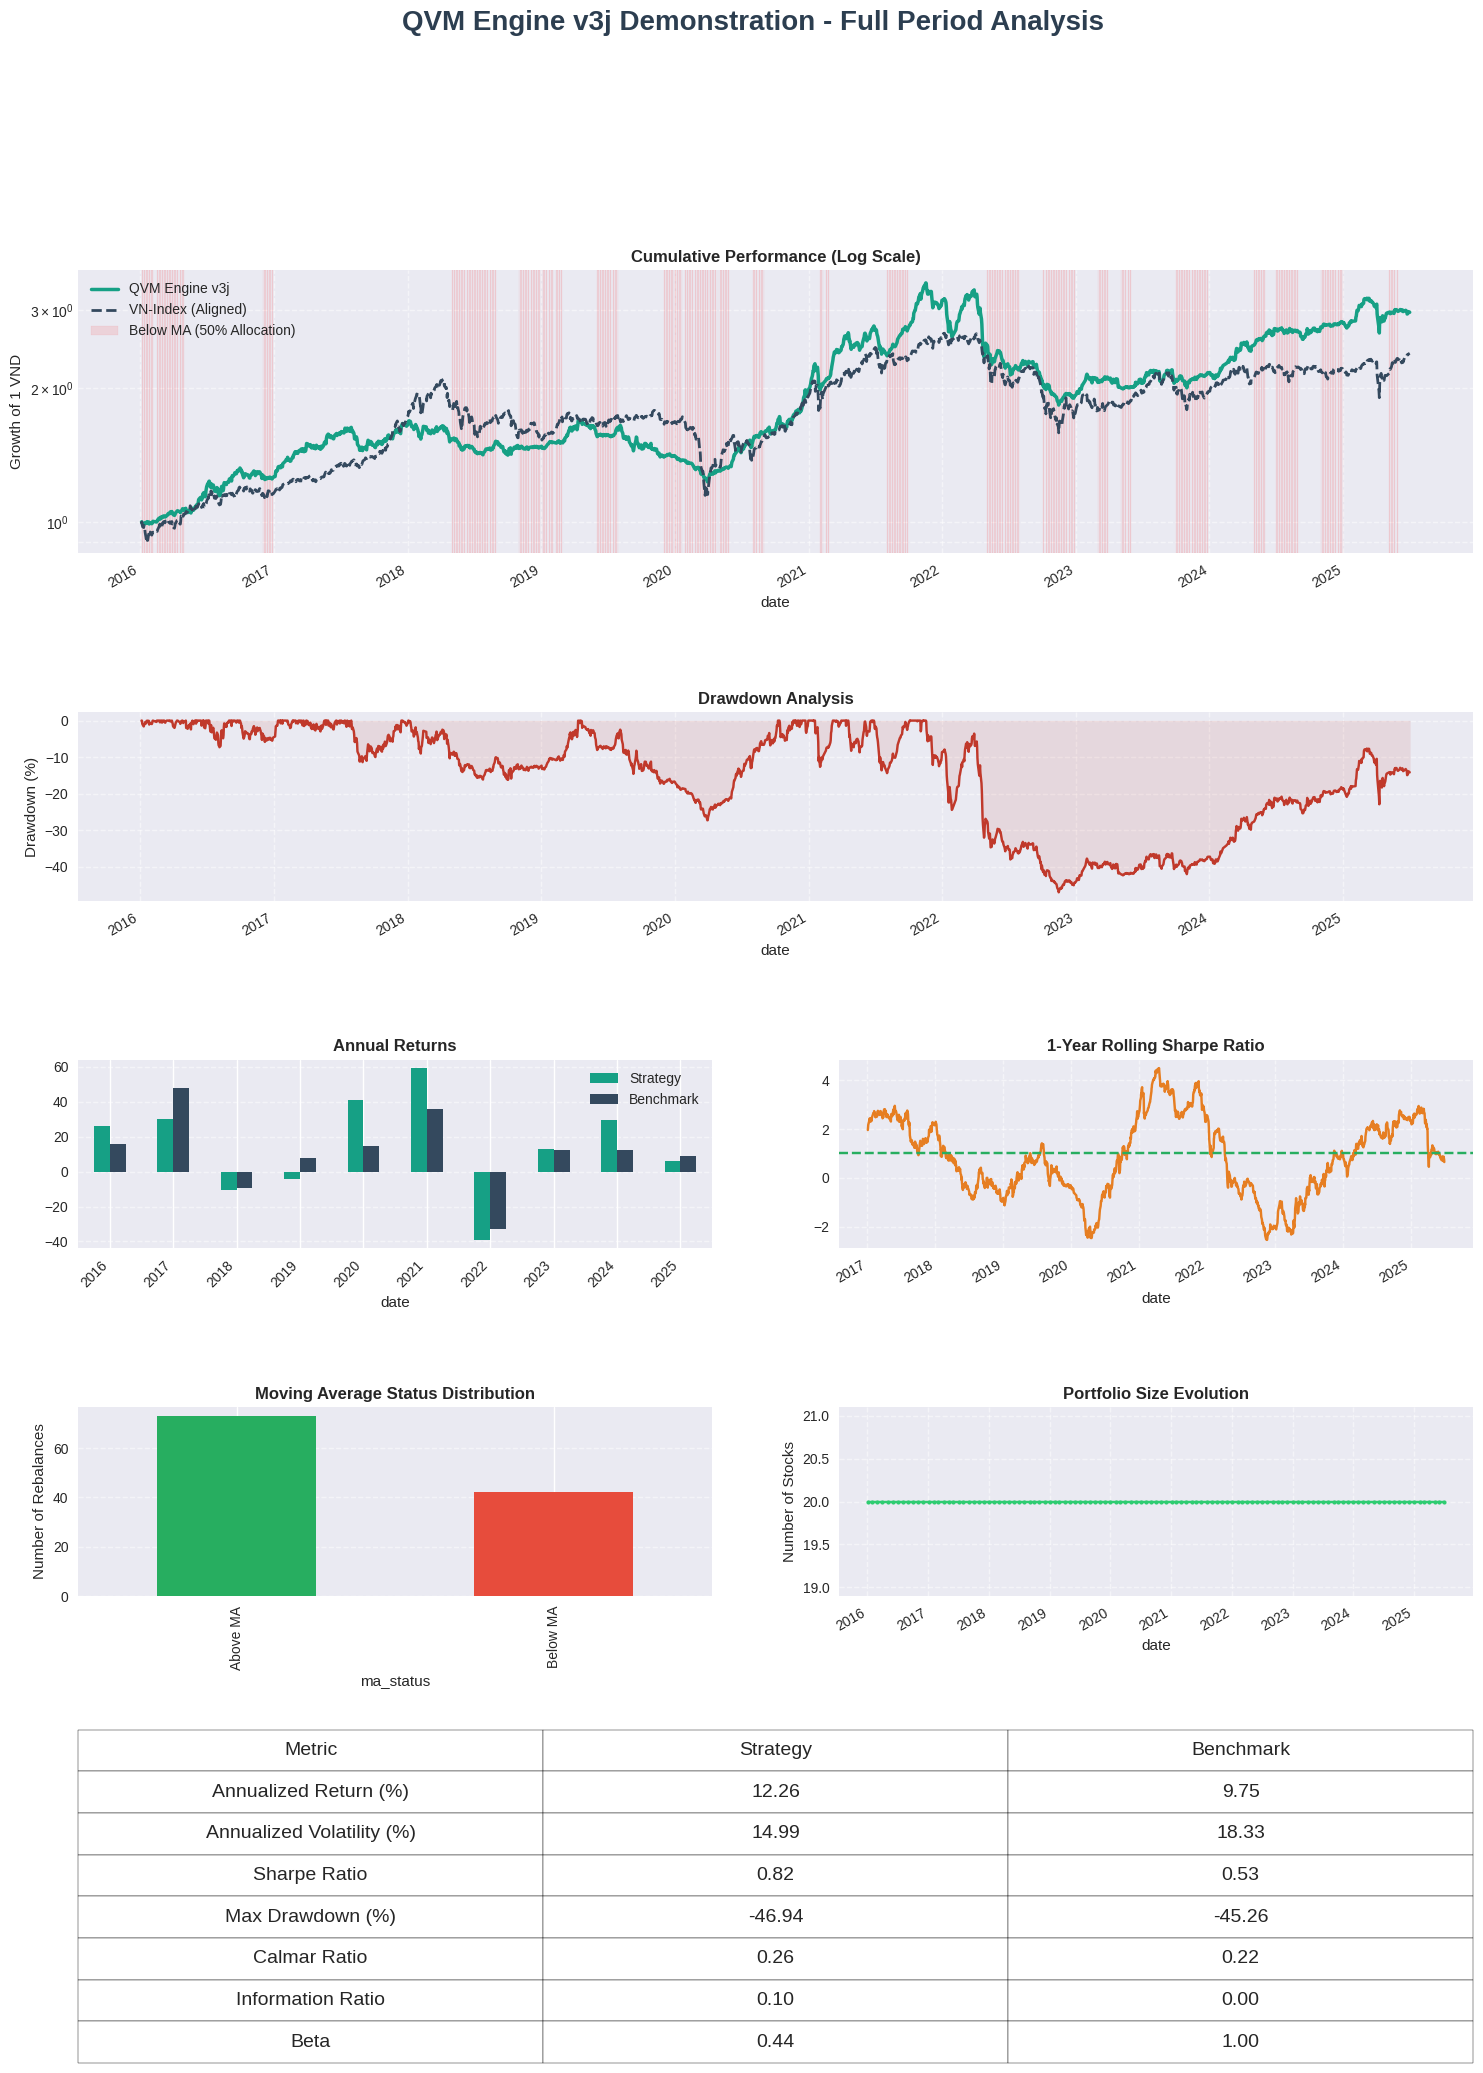

In [40]:
# Generate comprehensive tearsheet with new format
print("\n" + "="*80)
print("📊 QVM ENGINE V3J: COMPREHENSIVE TEARSHEET")
print("="*80)

# Convert daily returns to strategy returns series
strategy_returns = daily_returns.set_index('date')['portfolio_return']
benchmark_returns = benchmark_data.set_index('date')['close_price'].pct_change()

# Create diagnostics DataFrame with allocation and MA information
diagnostics = portfolio_values[['date', 'allocation', 'valid_holdings', 'ma_status']].copy()
diagnostics['portfolio_size'] = diagnostics['valid_holdings']
diagnostics = diagnostics.set_index('date')

# Generate the comprehensive tearsheet
generate_comprehensive_tearsheet(
    strategy_returns,
    benchmark_returns,
    diagnostics,
    "QVM Engine v3j Demonstration - Full Period Analysis"
)

# ADDITIONAL PERIOD TEARSHEETS


📊 QVM ENGINE V3J: FIRST PERIOD TEARSHEET (2016-2020)
   📊 Moving average shading applied


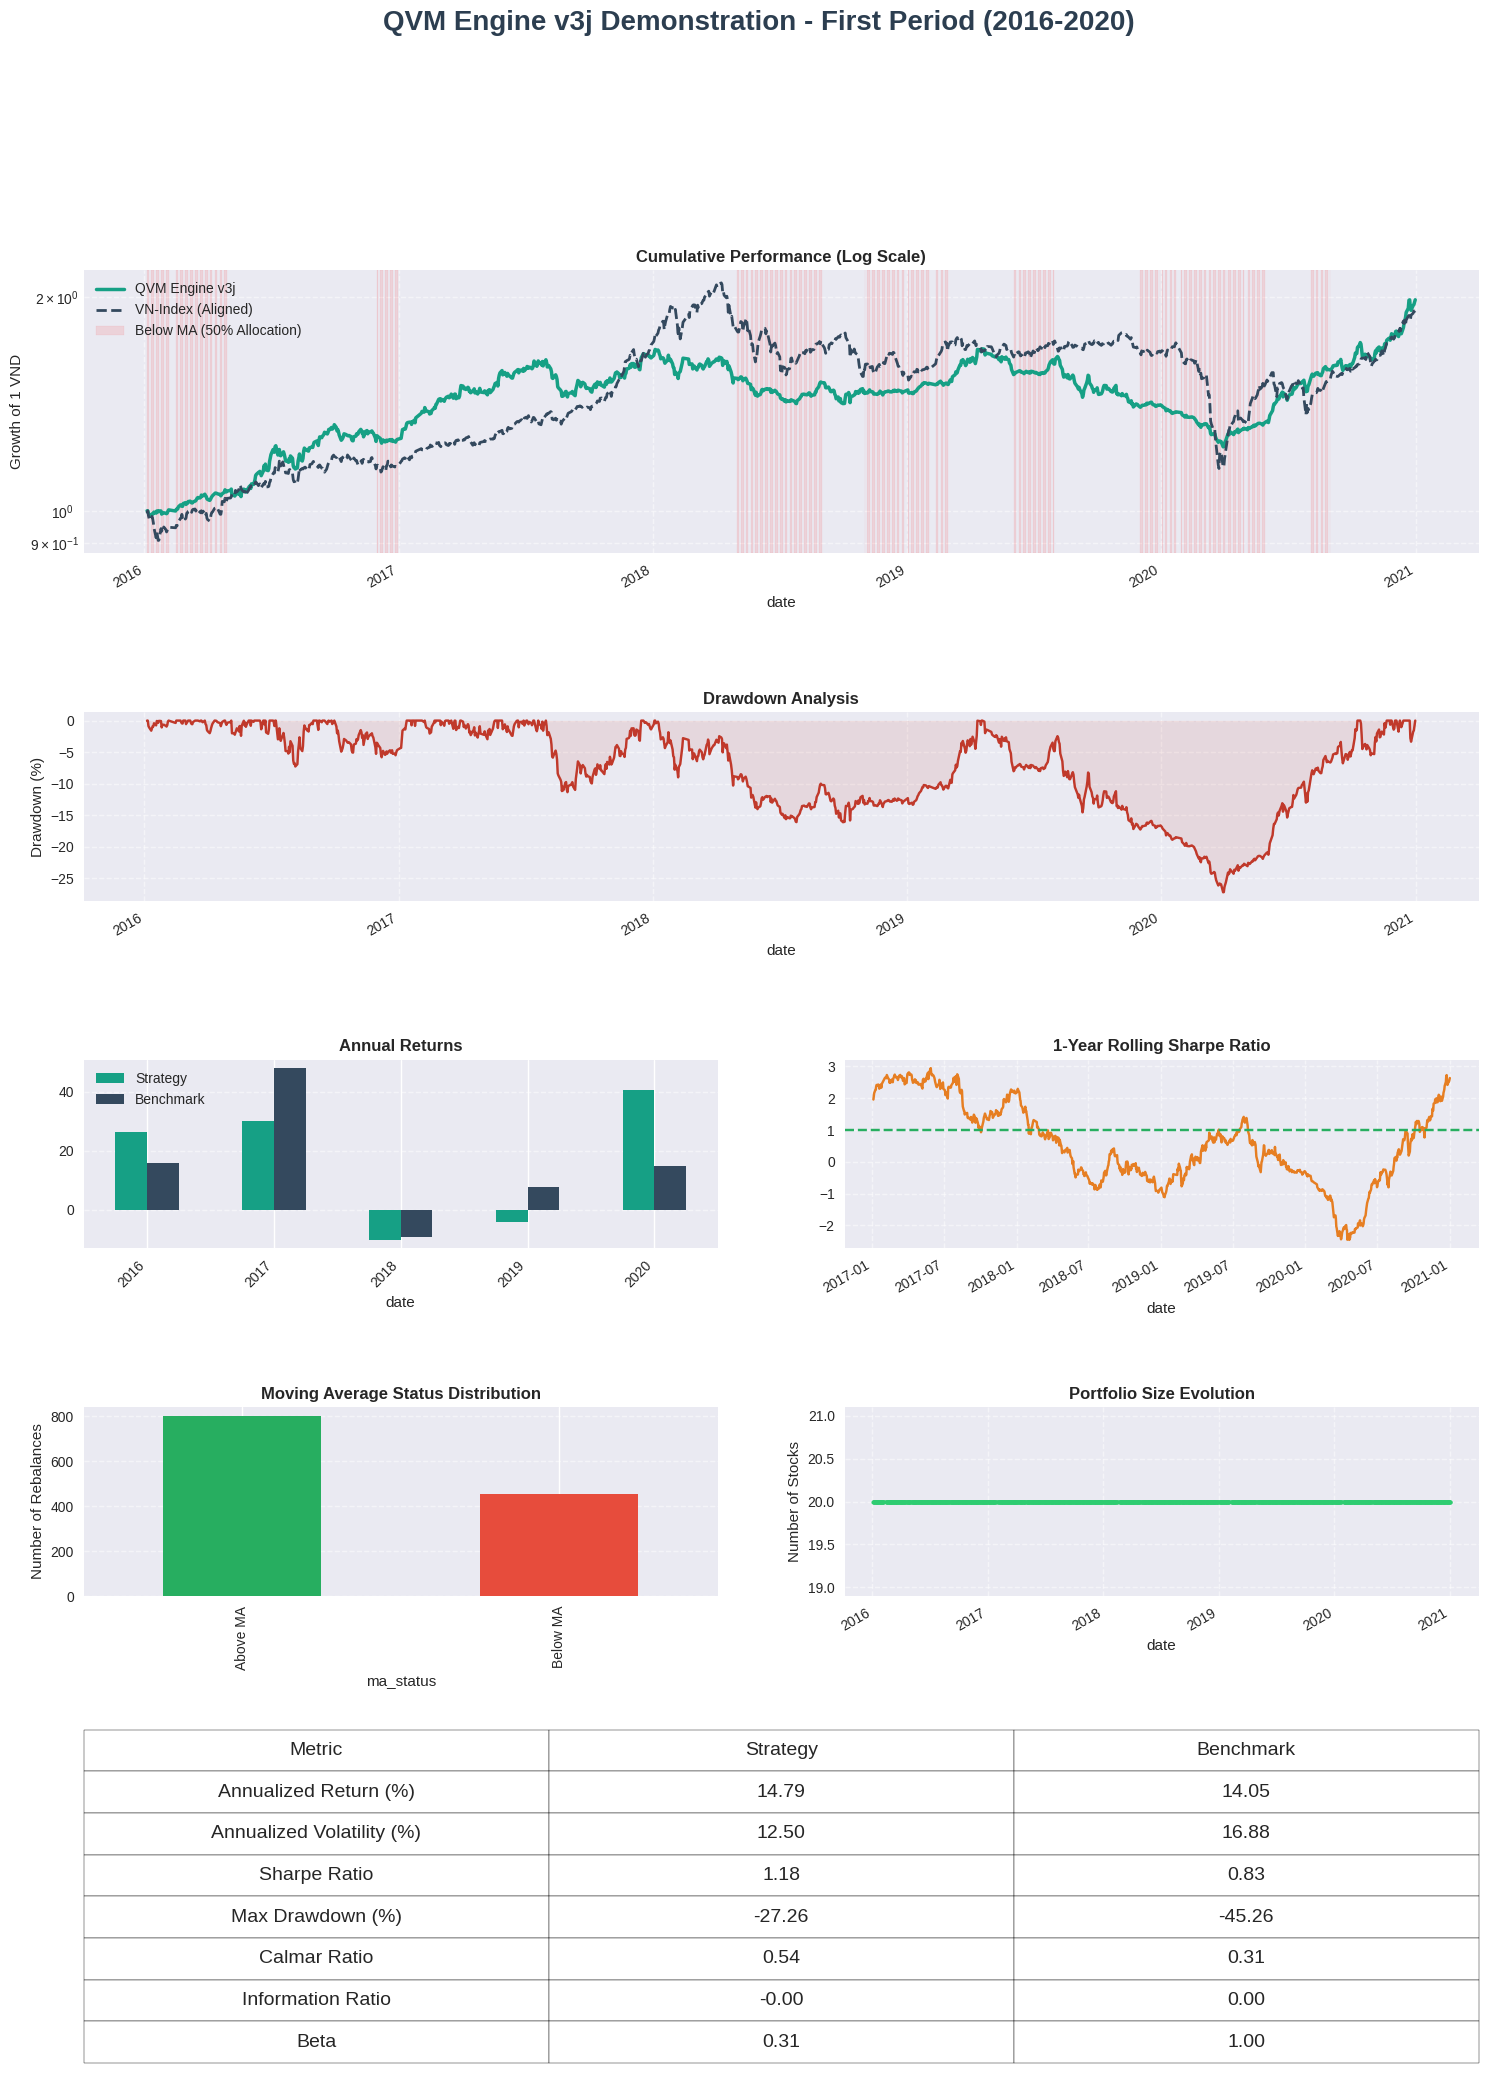


📊 QVM ENGINE V3J: SECOND PERIOD TEARSHEET (2020-2025)
   📊 Moving average shading applied


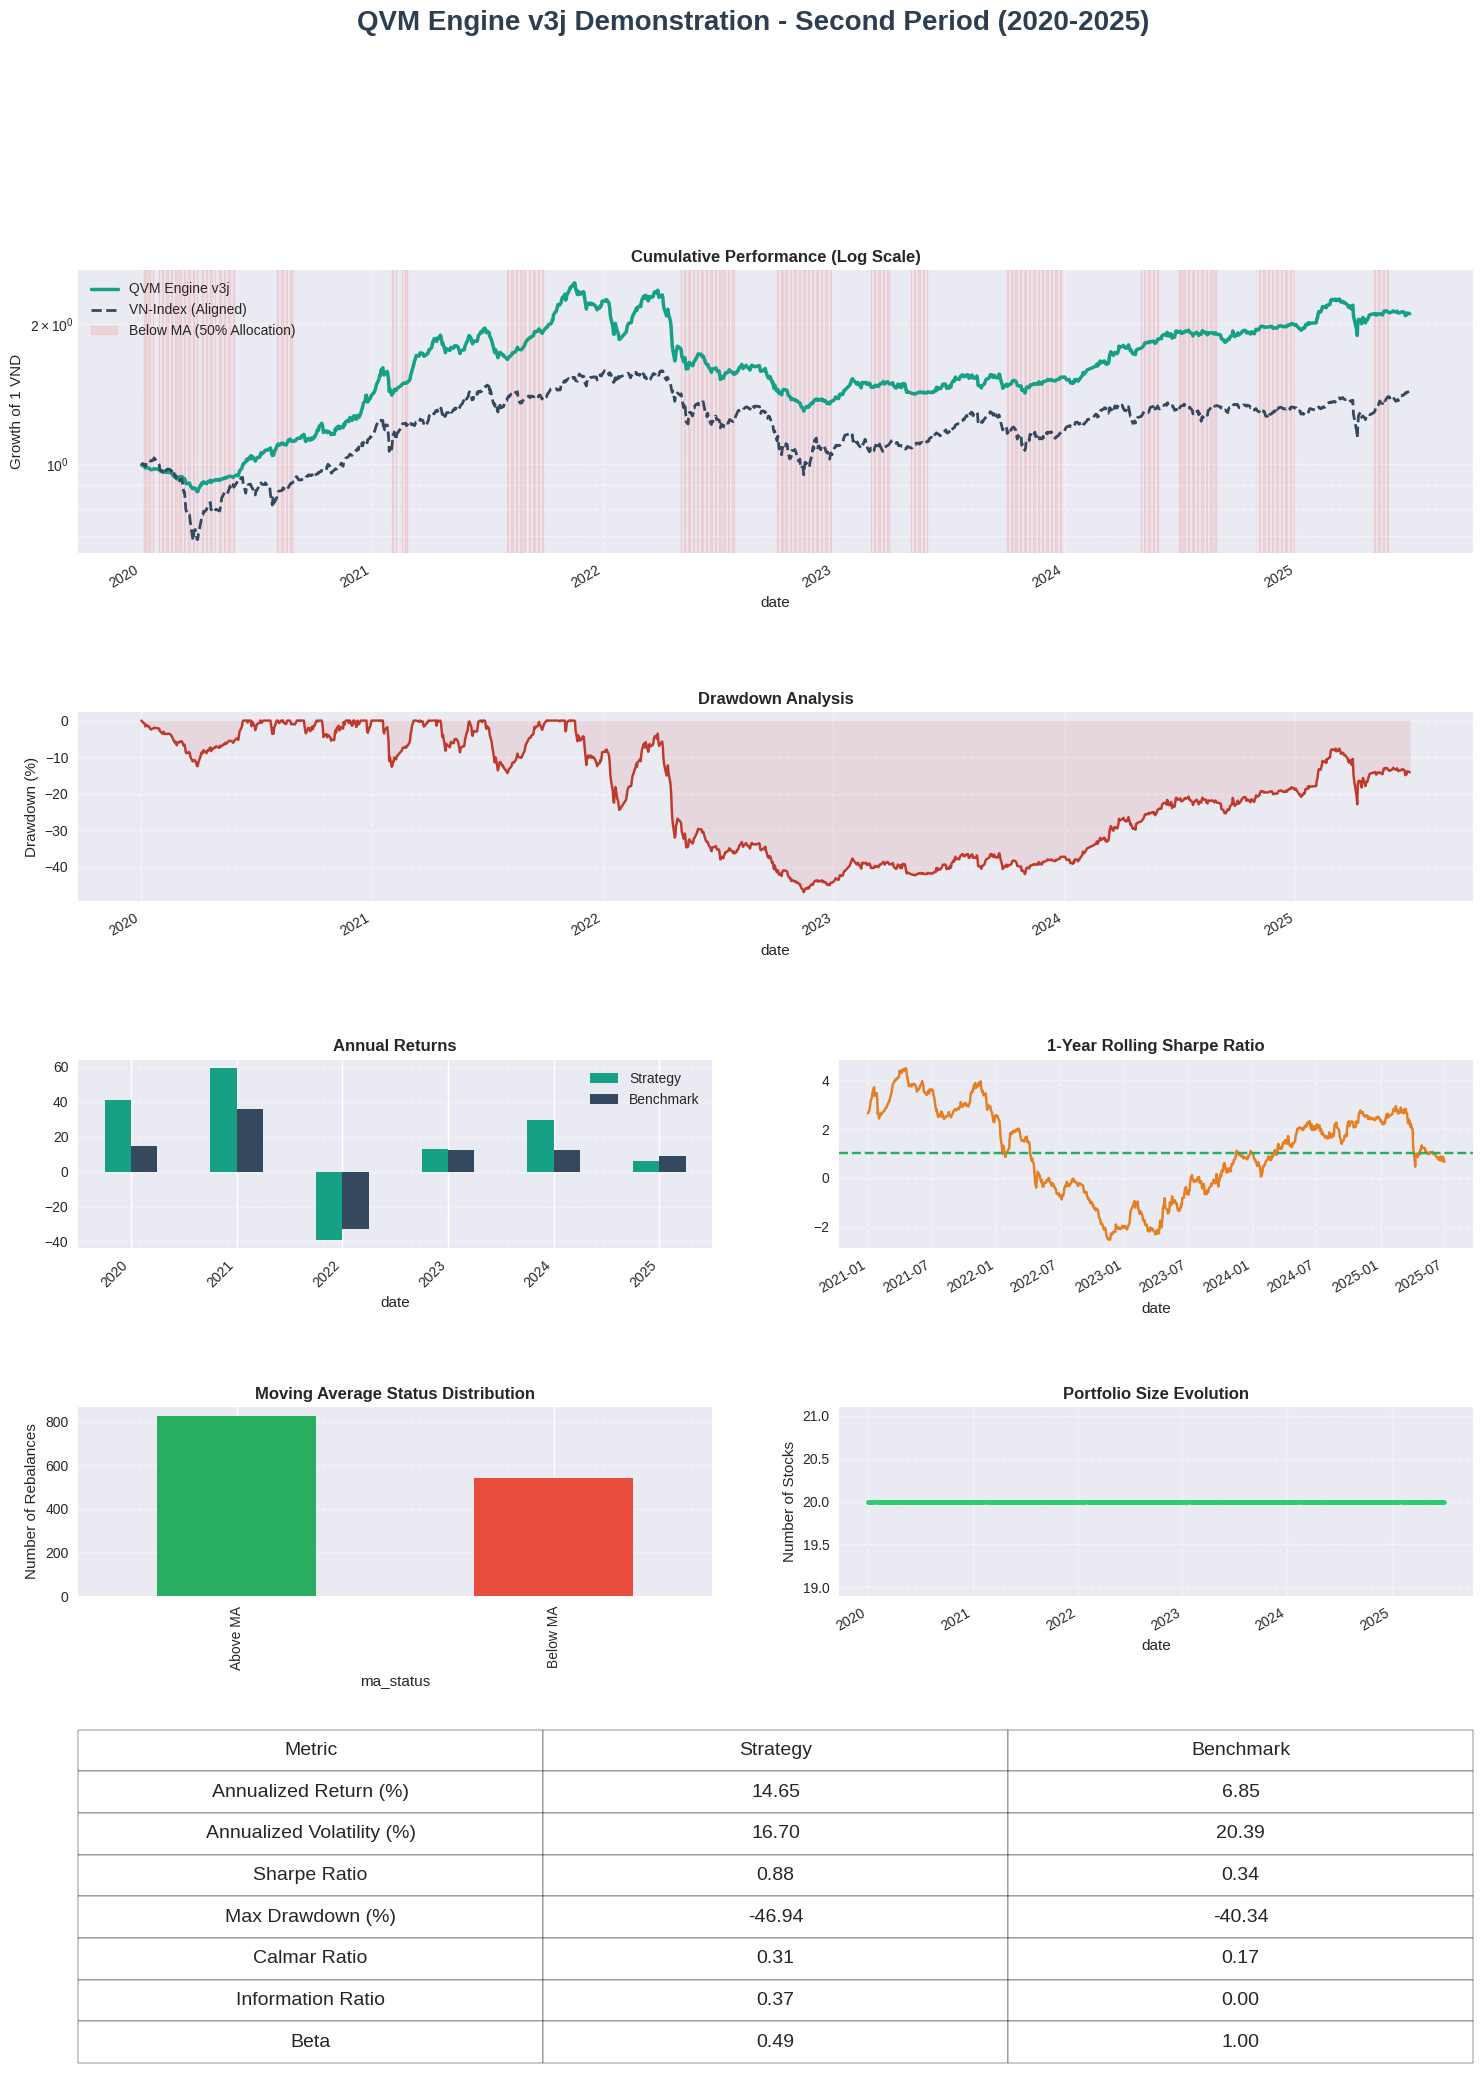

In [41]:
# 1. First Period Tearsheet (2016-2020)
print("\n" + "="*80)
print("📊 QVM ENGINE V3J: FIRST PERIOD TEARSHEET (2016-2020)")
print("="*80)

# Filter data for 2016-2020 period
first_period_mask = (strategy_returns.index >= '2016-01-01') & (strategy_returns.index <= '2020-12-31')
first_period_strategy_returns = strategy_returns[first_period_mask]
first_period_benchmark_returns = benchmark_returns.reindex(first_period_strategy_returns.index).fillna(0)
first_period_diagnostics = diagnostics.reindex(first_period_strategy_returns.index, method='ffill')

# Generate first period tearsheet
generate_comprehensive_tearsheet(
    first_period_strategy_returns,
    first_period_benchmark_returns,
    first_period_diagnostics,
    "QVM Engine v3j Demonstration - First Period (2016-2020)"
)

# 2. Second Period Tearsheet (2020-2025)
print("\n" + "="*80)
print("📊 QVM ENGINE V3J: SECOND PERIOD TEARSHEET (2020-2025)")
print("="*80)

# Filter data for 2020-2025 period
second_period_mask = (strategy_returns.index >= '2020-01-01') & (strategy_returns.index <= '2025-12-31')
second_period_strategy_returns = strategy_returns[second_period_mask]
second_period_benchmark_returns = benchmark_returns.reindex(second_period_strategy_returns.index).fillna(0)
second_period_diagnostics = diagnostics.reindex(second_period_strategy_returns.index, method='ffill')

# Generate second period tearsheet
generate_comprehensive_tearsheet(
    second_period_strategy_returns,
    second_period_benchmark_returns,
    second_period_diagnostics,
    "QVM Engine v3j Demonstration - Second Period (2020-2025)"
)

# SUMMARY

In [42]:
print("\n" + "="*80)
print("🎯 QVM STRATEGY PERFORMANCE SUMMARY")
print("="*80)
print(f"📈 Total Return: {performance_metrics['total_return']:.2%}")
print(f"📊 Annualized Return: {performance_metrics['annualized_return']:.2%}")
print(f"⚡ Sharpe Ratio: {performance_metrics['sharpe_ratio']:.3f}")
print(f"📉 Max Drawdown: {performance_metrics['max_drawdown']:.2%}")
print(f"🎯 Alpha: {performance_metrics['alpha']:.2%}")
print(f"📊 Beta: {performance_metrics['beta']:.3f}")
print(f"🏆 Win Rate: {performance_metrics['win_rate']:.2%}")
print("="*80)


🎯 QVM STRATEGY PERFORMANCE SUMMARY
📈 Total Return: 196.57%
📊 Annualized Return: 12.15%
⚡ Sharpe Ratio: 0.810
📉 Max Drawdown: -46.94%
🎯 Alpha: 7.83%
📊 Beta: 0.442
🏆 Win Rate: 55.04%
